#### Comprehensive CIFAR-100 Test Set Summary

| Model                 | Test Accuracy | Avg. KL Div (vs Teacher) | Avg. KL Div (Standardized) | Avg. Rank Correlation (vs Teacher) |
| :-------------------- | :------------ | :----------------------- | :------------------------- | :--------------------------------- |
| Teacher (VGG16)       | 74.00%        | -                        | -                          | -                                  |
| Student-Indep (VGG11) | 48.03%        | 0.0097                   | 0.0005                     | 0.5020                             |
| Student-KD (VGG11)    | 48.71%        | 0.0074                   | 0.0004                     | 0.6156                             |

#### Discussion and Interpretation

The experiments highlight a limitation of standard Knowledge Distillation (KD), where the KL divergence loss can be overly sensitive to the **magnitude** of logits rather than their relative **ranking**. The toy examples demonstrate this: the standard KL loss incorrectly favors the "Rank-Wrong" student (e.g., 0.1212 vs 0.6941 in the 10-class case) simply because its logit values are numerically closer to the teacher's, even though it produces the wrong prediction. This creates a misleading training signal that undermines the goal of transferring the teacher's "dark knowledge." Logit standardization directly addresses this by normalizing the logits, making the KD loss invariant to scale. This correctly assigns a near-zero loss to the rank-correct student and a higher loss to the incorrect one, realigning the training signal with the true objective.

This magnitude-rank conflict is not just theoretical. On the CIFAR-100 test set, we identified **597 "conflict" cases (5.97%)** where the standard KL loss preferred the KD student, even though that student's prediction disagreed with the teacher’s reasoning while the independent student's did not. Applying logit standardization successfully **corrected 69 of these conflicts (11.56%)**, meaning the loss for the rank-correct student became lower after normalization. This partial success confirms that logit magnitude is a significant source of instability in the KD training signal. However, since most cases remained uncorrected, it also implies that in many conflicts, the distilled student's logits are a poor match for the teacher's in terms of both shape and magnitude, a discrepancy that standardization alone cannot fully resolve.

### Toy Example 4 Class

In [7]:
import torch
import torch.nn.functional as F
import numpy as np

def logit_standardization(logits: torch.Tensor) -> torch.Tensor:
    mean = torch.mean(logits, dim=-1, keepdim=True)
    std = torch.std(logits, dim=-1, keepdim=True)
    return (logits - mean) / (std + 1e-8)

def calculate_kl(student_logits, teacher_logits, temperature=1.0, standardize=False):
    if standardize:
        student_logits_p = logit_standardization(student_logits)
        teacher_logits_p = logit_standardization(teacher_logits)
    else:
        student_logits_p = student_logits
        teacher_logits_p = teacher_logits
    teacher_probs = F.softmax(teacher_logits_p / temperature, dim=-1)
    student_log_probs = F.log_softmax(student_logits_p / temperature, dim=-1)
    kl_div = F.kl_div(student_log_probs, teacher_probs, reduction='sum')
    return max(kl_div.item(), 0.0)
    return kl_div.item()


CLASSES = ['Cat', 'Dog', 'Bird', 'Frog']

# logits from the paper's Figure 2
teacher_logits = torch.tensor([[1.0, 4.0, 3.0, 1.0]])
student1_logits = torch.tensor([[2.0, 2.8, 3.0, 1.0]]) # Magnitude-close, Rank-wrong
student2_logits = torch.tensor([[0.1, 0.4, 0.3, 0.1]]) # Magnitude-far, Rank-correct

teacher_pred = torch.argmax(teacher_logits, dim=-1).item()
s1_pred = torch.argmax(student1_logits, dim=-1).item()
s2_pred = torch.argmax(student2_logits, dim=-1).item()

print(f"Teacher Prediction: '{CLASSES[teacher_pred]}' (Correctly 'Dog')")
print(f"Student 1 Prediction: '{CLASSES[s1_pred]}' (Incorrectly 'Bird')")
print(f"Student 2 Prediction: '{CLASSES[s2_pred]}' (Correctly 'Dog')")
print("\n--- Before Standardization (Normal KD) ---")

# KL divergence without standardization
kl_s1_before = calculate_kl(student1_logits, teacher_logits)
kl_s2_before = calculate_kl(student2_logits, teacher_logits)

print(f"KL Div(Teacher || Student 1): {kl_s1_before:.4f}")
print(f"KL Div(Teacher || Student 2): {kl_s2_before:.4f}")
print(f"Student 1 has a LOWER loss ({kl_s1_before:.4f} < {kl_s2_before:.4f}),")

print("\n--- Analysis After Logit Standardization ---")

# KL divergence WITH standardization
kl_s1_after = calculate_kl(student1_logits, teacher_logits, standardize=True)
kl_s2_after = calculate_kl(student2_logits, teacher_logits, standardize=True)

print(f"KL Div(Teacher || Student 1): {kl_s1_after:.4f}")
print(f"KL Div(Teacher || Student 2): {kl_s2_after:.4f}")
print(f"\n Student 2 has a lower loss ({kl_s2_after:.4f} << {kl_s1_after:.4f}).")

Teacher Prediction: 'Dog' (Correctly 'Dog')
Student 1 Prediction: 'Bird' (Incorrectly 'Bird')
Student 2 Prediction: 'Dog' (Correctly 'Dog')

--- Before Standardization (Normal KD) ---
KL Div(Teacher || Student 1): 0.2427
KL Div(Teacher || Student 2): 0.4274
Student 1 has a LOWER loss (0.2427 < 0.4274),

--- Analysis After Logit Standardization ---
KL Div(Teacher || Student 1): 0.1087
KL Div(Teacher || Student 2): 0.0000

 Student 2 has a lower loss (0.0000 << 0.1087).


### Toy Example 10 Class

In [8]:
import torch
import torch.nn.functional as F
import numpy as np

def logit_standardization(logits: torch.Tensor) -> torch.Tensor:
    mean = torch.mean(logits, dim=-1, keepdim=True)
    std = torch.std(logits, dim=-1, keepdim=True)
    return (logits - mean) / (std + 1e-8)

def calculate_kl(student_logits, teacher_logits, temperature=1.0, standardize=False):
    student_logits = student_logits.float()
    teacher_logits = teacher_logits.float()

    if standardize:
        student_logits_p = logit_standardization(student_logits)
        teacher_logits_p = logit_standardization(teacher_logits)
    else:
        student_logits_p = student_logits
        teacher_logits_p = teacher_logits

    teacher_probs = F.softmax(teacher_logits_p / temperature, dim=-1)
    student_log_probs = F.log_softmax(student_logits_p / temperature, dim=-1)
    kl_div = F.kl_div(student_log_probs, teacher_probs, reduction='batchmean')
    return max(kl_div.item(), 0.0)

# Teacher's top two logits (at indices 2 and 4) are close.
teacher_logits_10 = torch.tensor([[1.0, 2.0, 8.0, 3.0, 7.5, 1.5, -2.0, 0.5, -1.0, 2.5]])
# Correct class is index 2.

# Student 1: Swaps top two logits (indices 2 and 4). Magnitudes are very close, rank is wrong.
student1_logits_10 = torch.tensor([[1.0, 2.0, 7.5, 3.0, 8.0, 1.5, -2.0, 0.5, -1.0, 2.5]])

# Student 2: Scales down teacher logits. Magnitudes are far, rank is correct.
student2_logits_10 = teacher_logits_10 / 5.0

teacher_pred_10 = torch.argmax(teacher_logits_10, dim=-1).item()
s1_pred_10 = torch.argmax(student1_logits_10, dim=-1).item()
s2_pred_10 = torch.argmax(student2_logits_10, dim=-1).item()

print(f"Teacher Prediction: Correct class is index {teacher_pred_10}")
print(f"Student 1 Prediction: Incorrectly predicts index {s1_pred_10}")
print(f"Student 2 Prediction: Correctly predicts index {s2_pred_10}")

# 3. Analyze Before Standardization
print("\n--- Before Standardization (Normal KD) ---")

kl_s1_before_10 = calculate_kl(student1_logits_10, teacher_logits_10)
kl_s2_before_10 = calculate_kl(student2_logits_10, teacher_logits_10)

print(f"KL Div(Teacher || Student 1): {kl_s1_before_10:.4f}")
print(f"KL Div(Teacher || Student 2): {kl_s2_before_10:.4f}")

if kl_s1_before_10 < kl_s2_before_10:
    print(f"\n Student 1 has a LOWER loss ({kl_s1_before_10:.4f} < {kl_s2_before_10:.4f}),")
else:
    print("\n[Analysis Failed] The example did not produce the desired misleading signal.")

print("\n--- After Logit Standardization ---")

kl_s1_after_10 = calculate_kl(student1_logits_10, teacher_logits_10, standardize=True)
kl_s2_after_10 = calculate_kl(student2_logits_10, teacher_logits_10, standardize=True)

print(f"KL Div(Teacher || Student 1): {kl_s1_after_10:.4f}")
print(f"KL Div(Teacher || Student 2): {kl_s2_after_10:.4f}")
print(f"\n After standardization, Student 2 has the minimal loss ({kl_s2_after_10:.4f} << {kl_s1_after_10:.4f}).")

Teacher Prediction: Correct class is index 2
Student 1 Prediction: Incorrectly predicts index 4
Student 2 Prediction: Correctly predicts index 2

--- Before Standardization (Normal KD) ---
KL Div(Teacher || Student 1): 0.1212
KL Div(Teacher || Student 2): 0.6941

 Student 1 has a LOWER loss (0.1212 < 0.6941),

--- After Logit Standardization ---
KL Div(Teacher || Student 1): 0.0076
KL Div(Teacher || Student 2): 0.0000

 After standardization, Student 2 has the minimal loss (0.0000 << 0.0076).


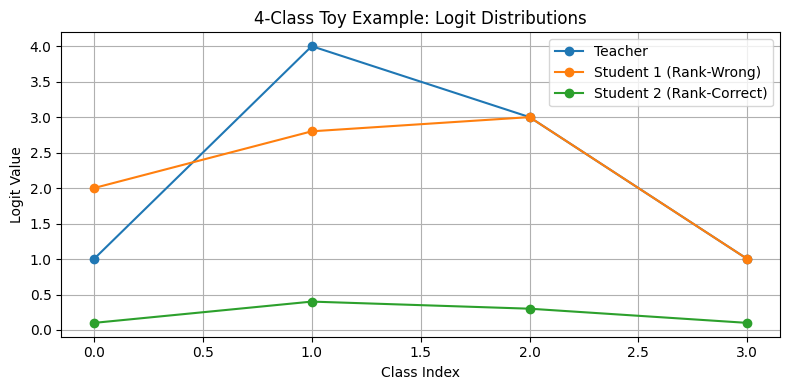

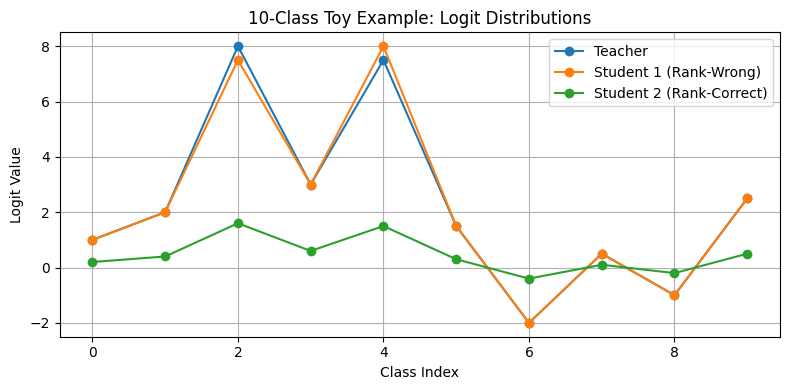


=== Summary Table ===
   Setup  KL_S1_Before  KL_S2_Before  KL_S1_After  KL_S2_After Correct_Student
 4-Class      0.242692      0.427429     0.108688          0.0              S2
10-Class      0.121219      0.694092     0.007630          0.0              S2


In [9]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_logits(logits_dict, title):
    plt.figure(figsize=(8, 4))
    for name, logits in logits_dict.items():
        plt.plot(range(len(logits[0])), logits[0], marker='o', label=name)
    plt.title(title)
    plt.xlabel('Class Index')
    plt.ylabel('Logit Value')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# === 4-Class Plot ===
plot_logits({
    "Teacher": teacher_logits,
    "Student 1 (Rank-Wrong)": student1_logits,
    "Student 2 (Rank-Correct)": student2_logits
}, "4-Class Toy Example: Logit Distributions")

# === 10-Class Plot ===
plot_logits({
    "Teacher": teacher_logits_10,
    "Student 1 (Rank-Wrong)": student1_logits_10,
    "Student 2 (Rank-Correct)": student2_logits_10
}, "10-Class Toy Example: Logit Distributions")

# === Summary Table ===
toy_summary = pd.DataFrame({
    "Setup": ["4-Class", "10-Class"],
    "KL_S1_Before": [kl_s1_before, kl_s1_before_10],
    "KL_S2_Before": [kl_s2_before, kl_s2_before_10],
    "KL_S1_After": [kl_s1_after, kl_s1_after_10],
    "KL_S2_After": [kl_s2_after, kl_s2_after_10],
    "Correct_Student": ["S2", "S2"]
})

print("\n=== Summary Table ===")
print(toy_summary.to_string(index=False))


### Loading Models

In [4]:
import torch
from model import get_model
from data_utils import get_cifar100_loaders
from train_eval import evaluate
import torch.nn.functional as F

device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_loader, test_loader = get_cifar100_loaders(batch_size=128)
teacher = get_model('vgg16_bn', pretrained=True, num_classes=100).to(device)
teacher.eval()
student_kd = get_model('vgg11_bn', pretrained=False, num_classes=100).to(device)
student_kd.load_state_dict(torch.load('distilled_student.pth', map_location=device))
student_kd.eval()
student_indep = get_model('vgg11_bn', pretrained=False, num_classes=100).to(device)
student_indep.load_state_dict(torch.load('vgg11_bn_finetuned.pth', map_location=device))
student_indep.eval()


100%|██████████| 169M/169M [00:13<00:00, 12.6MB/s]
/usr/local/lib/python3.12/dist-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(


Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/zipball/master" to /root/.cache/torch/hub/master.zip
Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/releases/download/vgg/cifar100_vgg16_bn-7d8c4031.pt" to /root/.cache/torch/hub/checkpoints/cifar100_vgg16_bn-7d8c4031.pt


100%|██████████| 58.4M/58.4M [00:01<00:00, 33.5MB/s]
Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

### Analysis

In [5]:
import torch
import torch.nn.functional as F
from model import get_model
from data_utils import get_cifar100_loaders
import os

device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_loader, test_loader = get_cifar100_loaders(batch_size=256, num_workers=2)
num_examples_to_inspect = 5
T = 3.0
@torch.no_grad()
def collect_logits(model, loader, max_batches=None):
    model.eval()
    logits_list = []
    labels_list = []
    for i, (x, y) in enumerate(loader):
        x = x.to(device)
        logits = model(x)               # logits (pre-softmax)
        logits_list.append(logits.cpu())
        labels_list.append(y)
        if max_batches and i+1 >= max_batches:
            break
    return torch.cat(logits_list, dim=0), torch.cat(labels_list, dim=0)

print("Collecting train logits ...")
train_teacher_logits, train_labels = collect_logits(teacher, train_loader)
train_indep_logits, _ = collect_logits(student_indep, train_loader)
train_kd_logits, _    = collect_logits(student_kd, train_loader)
print("Train logits collected:", train_teacher_logits.shape)

print("Collecting test logits...")
test_teacher_logits, test_labels = collect_logits(teacher, test_loader)
test_indep_logits, _ = collect_logits(student_indep, test_loader)
test_kd_logits, _    = collect_logits(student_kd, test_loader)
print("Test logits collected:", test_teacher_logits.shape)

def per_sample_kl(teacher_logits, student_logits, T=1.0):
    # teacher_probs: p_t, student_log_probs: log p_s
    p_t = F.softmax(teacher_logits / T, dim=1)            # [N, C]
    log_p_s = F.log_softmax(student_logits / T, dim=1)    # [N, C]
    log_p_t = torch.log(p_t + 1e-12)
    kl = (p_t * (log_p_t - log_p_s)).mean(dim=1)  # [N]
    return kl

# Logit standardization
def standardize_logits(logits):
    mean = logits.mean(dim=1, keepdim=True)
    std = logits.std(dim=1, keepdim=True)
    return (logits - mean) / (std + 1e-8)

def analyze_split(teacher_logits, indep_logits, kd_logits, labels, split_name="split"):
    n = labels.size(0)
    with torch.no_grad():
        # preds
        teacher_pred = teacher_logits.argmax(dim=1)
        indep_pred = indep_logits.argmax(dim=1)
        kd_pred = kd_logits.argmax(dim=1)

        # per-sample KL
        kl_indep = per_sample_kl(teacher_logits, indep_logits, T=T)
        kl_kd    = per_sample_kl(teacher_logits, kd_logits, T=T)

        # KD lower KL but KD disagrees with teacher, indep agrees with teacher OR indep matches gold
        indep_matches = (indep_pred == teacher_pred) | (indep_pred == labels)
        kd_disagrees_teacher = (kd_pred != teacher_pred)

        conflict_mask = (kl_kd < kl_indep) & kd_disagrees_teacher & indep_matches

        conflict_indices = torch.nonzero(conflict_mask).squeeze(1).cpu().tolist()
        num_conflicts = len(conflict_indices)

        t_std = standardize_logits(teacher_logits)
        indep_std = standardize_logits(indep_logits)
        kd_std = standardize_logits(kd_logits)

        kl_indep_std = per_sample_kl(t_std, indep_std, T=T)
        kl_kd_std    = per_sample_kl(t_std, kd_std, T=T)
        corrected = 0
        corrected_examples = []
        for idx in conflict_indices:
            if kl_indep_std[idx] < kl_kd_std[idx]:
                corrected += 1
                if len(corrected_examples) < num_examples_to_inspect:
                    corrected_examples.append(idx)

        # Build summary and some examples
        fraction = num_conflicts / float(n)
        corrected_frac = corrected / float(num_conflicts) if num_conflicts > 0 else 0.0

        print(f"\n=== {split_name.upper()} SUMMARY ===")
        print(f"Total samples inspected: {n}")
        print(f"Conflicts found (KD lower KL but KD disagrees with teacher & Indep matches teacher/gold): {num_conflicts} ({fraction*100:.3f}%)")
        print(f"After logit-standardization, conflicts corrected: {corrected}/{num_conflicts} ({corrected_frac*100:.2f}%)")

        # Show a few example cases (before and after KLs)
        if num_conflicts > 0:
            print(f"\nShowing up to {num_examples_to_inspect} example conflict indices (index, label, teacher_pred, indep_pred, kd_pred):")
            for i, idx in enumerate(conflict_indices[:num_examples_to_inspect]):
                print(f"#{i+1}: idx={idx}, label={labels[idx].item()}, teacher={teacher_pred[idx].item()}, "
                      f"indep={indep_pred[idx].item()}, kd={kd_pred[idx].item()}")
                print(f"   KL_indep_before={kl_indep[idx].item():.6f}, KL_kd_before={kl_kd[idx].item():.6f}")
                print(f"   KL_indep_std = {kl_indep_std[idx].item():.6f}, KL_kd_std = {kl_kd_std[idx].item():.6f}")
        else:
            print("No conflicts found in this split.")

        return {
            'n': n,
            'num_conflicts': num_conflicts,
            'fraction': fraction,
            'corrected': corrected,
            'corrected_frac': corrected_frac,
            'example_indices': conflict_indices[:num_examples_to_inspect]
        }

train_report = analyze_split(train_teacher_logits, train_indep_logits, train_kd_logits, train_labels, split_name="train")
test_report  = analyze_split(test_teacher_logits, test_indep_logits, test_kd_logits, test_labels, split_name="test")

import pandas as pd

summary_table = pd.DataFrame([
    {
        "Split": "Train",
        "Total Samples": train_report['n'],
        "Conflicts": train_report['num_conflicts'],
        "Conflict %": f"{train_report['fraction']*100:.3f}%",
        "Corrected": train_report['corrected'],
        "Corrected %": f"{train_report['corrected_frac']*100:.2f}%"
    },
    {
        "Split": "Test",
        "Total Samples": test_report['n'],
        "Conflicts": test_report['num_conflicts'],
        "Conflict %": f"{test_report['fraction']*100:.3f}%",
        "Corrected": test_report['corrected'],
        "Corrected %": f"{test_report['corrected_frac']*100:.2f}%"
    }
])

print("\n=== CIFAR-100 Conflict Summary Table ===")
print(summary_table.to_string(index=False))



Train logits collected: torch.Size([50000, 100])
Test logits collected: torch.Size([10000, 100])

=== TRAIN SUMMARY ===
Total samples inspected: 50000
Conflicts found (KD lower KL but KD disagrees with teacher & Indep matches teacher/gold): 8 (0.016%)
After logit-standardization, conflicts corrected: 2/8 (25.00%)

Showing up to 5 example conflict indices (index, label, teacher_pred, indep_pred, kd_pred):
#1: idx=1122, label=95, teacher=95, indep=95, kd=30
   KL_indep_before=0.006133, KL_kd_before=0.004190
   KL_indep_std = 0.000573, KL_kd_std = 0.000181
#2: idx=7706, label=5, teacher=5, indep=5, kd=25
   KL_indep_before=0.013276, KL_kd_before=0.007778
   KL_indep_std = 0.000576, KL_kd_std = 0.000391
#3: idx=11935, label=34, teacher=34, indep=34, kd=42
   KL_indep_before=0.020105, KL_kd_before=0.015992
   KL_indep_std = 0.000548, KL_kd_std = 0.000568
#4: idx=19067, label=74, teacher=74, indep=74, kd=50
   KL_indep_before=0.012119, KL_kd_before=0.009848
   KL_indep_std = 0.000458, KL_kd_

In [6]:
import pandas as pd
from scipy.stats import spearmanr
import numpy as np

# --- 1. Prediction Correctness (Accuracy) ---
teacher_preds = test_teacher_logits.argmax(dim=1)
indep_preds = test_indep_logits.argmax(dim=1)
kd_preds = test_kd_logits.argmax(dim=1)

teacher_acc = (teacher_preds == test_labels).float().mean().item()
indep_acc = (indep_preds == test_labels).float().mean().item()
kd_acc = (kd_preds == test_labels).float().mean().item()

# --- 2. Ranking Correlation (Spearman) ---
def avg_spearman_correlation(logits1, logits2):
    correlations = []
    for i in range(logits1.shape[0]):
        corr, _ = spearmanr(logits1[i].numpy(), logits2[i].numpy())
        correlations.append(corr)
    return np.mean(correlations)

corr_indep = avg_spearman_correlation(test_teacher_logits, test_indep_logits)
corr_kd = avg_spearman_correlation(test_teacher_logits, test_kd_logits)

# --- 3. Average KL Divergence ---
# Calculate KL before standardization
avg_kl_indep_before = per_sample_kl(test_teacher_logits, test_indep_logits, T=T).mean().item()
avg_kl_kd_before = per_sample_kl(test_teacher_logits, test_kd_logits, T=T).mean().item()

# Calculate KL after standardization
t_std = standardize_logits(test_teacher_logits)
indep_std = standardize_logits(test_indep_logits)
kd_std = standardize_logits(test_kd_logits)
avg_kl_indep_after = per_sample_kl(t_std, indep_std, T=T).mean().item()
avg_kl_kd_after = per_sample_kl(t_std, kd_std, T=T).mean().item()


# --- 4. Summary Table ---
summary_data = {
    "Model": ["Teacher (VGG16)", "Student-Indep (VGG11)", "Student-KD (VGG11)"],
    "Test Accuracy": [f"{teacher_acc:.2%}", f"{indep_acc:.2%}", f"{kd_acc:.2%}"],
    "Avg. KL Div (vs Teacher)": ["-", f"{avg_kl_indep_before:.4f}", f"{avg_kl_kd_before:.4f}"],
    "Avg. KL Div (Standardized)": ["-", f"{avg_kl_indep_after:.4f}", f"{avg_kl_kd_after:.4f}"],
    "Avg. Rank Correlation (vs Teacher)": ["-", f"{corr_indep:.4f}", f"{corr_kd:.4f}"],
}

summary_df = pd.DataFrame(summary_data)
print("=== Comprehensive CIFAR-100 Test Set Summary ===\n")
print(summary_df.to_string(index=False))

=== Comprehensive CIFAR-100 Test Set Summary ===

                Model Test Accuracy Avg. KL Div (vs Teacher) Avg. KL Div (Standardized) Avg. Rank Correlation (vs Teacher)
      Teacher (VGG16)        74.00%                        -                          -                                  -
Student-Indep (VGG11)        48.03%                   0.0097                     0.0005                             0.5020
   Student-KD (VGG11)        48.71%                   0.0074                     0.0004                             0.6156
